In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44695,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40245,Total threads: 2
Dashboard: /proxy/44775/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:32883,


In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl_sst = ctrl_sst.sst.compute()

In [4]:
VC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
VC_sst = VC_sst.sst.compute()

In [5]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [6]:
ctrl_sst = roll_lon(ctrl_sst)

In [7]:
VC_sst = roll_lon(VC_sst)

In [8]:
#fucntions to look at IOD events
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(yt_ocean=slice(-5, 5),xt_ocean=slice(190, 240)).mean(['yt_ocean', 'xt_ocean'])
     
def IOBM(DS):
    return ssta(DS).sel(yt_ocean=slice(-20, 20),xt_ocean=slice(40, 100)).mean(['yt_ocean', 'xt_ocean'])
def NINO34(DS):
    return ssta(DS).sel(yt_ocean=slice(-5, 5),xt_ocean=slice(190, 240)).mean(['yt_ocean', 'xt_ocean'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = ssta(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO-SETIO).drop('month')
def eio(DS):
    SETIO = ssta(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (SETIO).drop('month')
def eio_1(DS):
    SETIO = (DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (SETIO)
def wio(DS):
    WTIO = ssta(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO).drop('month')
def wio_1(DS):
    WTIO = (DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO)

In [9]:
def n34_non_events(ds):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = NINO34(ds).resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    DJF = QS.groupby('time.season')["DJF"]
    #now use this to select all events and create da's of el Nino and la Nina event values
    lower,upper = DJF.quantile([0.15, 0.85])
    events_1 = DJF.where(DJF > lower.values).dropna(dim = "time")
    events_2 = events_1.where(DJF < upper.values).dropna(dim = "time")
    return events_2

In [10]:
def n34_events(ds):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = NINO34(ds).resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    DJF = QS.groupby('time.season')["DJF"]
    #now use this to select all events and create da's of el Nino and la Nina event values
    lower,upper = DJF.quantile([0.15, 0.85])
    lN = DJF.where(DJF <= lower.values).dropna(dim = "time")
    eN = DJF.where(DJF > upper.values).dropna(dim = "time")
    return lN, eN

In [11]:
def IOD_events(ds):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = dmi(ds).resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    #now use this to select all events and create da's of niod and piod event values
    lower,upper = SON.quantile([0.15, 0.85])
    nIOD = SON.where(SON <= lower.values).dropna(dim = "time")
    pIOD = SON.where(SON > upper.values).dropna(dim = "time")
    return nIOD, pIOD
def get_IOD_times(ds_sst, ds_var):
    nIOD, pIOD = IOD_events(ds_sst)
    #now get the times where the variable is in SON
    SON_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    #Now use nIOd and PIOD to get the times that we want
    nIOD_var = SON_var.where(SON_var.time == nIOD.time).dropna(dim = "time")
    pIOD_var = SON_var.where(SON_var.time == pIOD.time).dropna(dim = "time")
    return nIOD_var, pIOD_var

In [12]:
def get_IOD_times(ds_sst, ds_var):
    nIOD, pIOD = IOD_events(ds_sst)
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    #now get the ds_var groupbed by year for each season. 
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    # Initialize an empty list to store the subsets
    pos_list = []
    neg_list = []
    # Loop through each year group in ds_var and subset based on the specific years in both nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    # Combine the subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    return subset_ds_pos, subset_ds_neg

In [13]:
def pure_cooc_events(ds):
    #define ENSO events, pos neg and non ENSO
    non_enso = n34_non_events(ds)
    LN, EN = n34_events(ds)
    #define IOD events (pos and neg only)
    nIOD, pIOD = IOD_events(ds)
    #now convert these to years so we can find the intersection of them
    non_EN_yrs = non_enso.groupby('time.year').mean("time")
    EN_yrs = EN.groupby('time.year').mean("time")
    pIOD_yrs = pIOD.groupby('time.year').mean("time")
    LN_yrs = LN.groupby('time.year').mean("time")
    nIOD_yrs = nIOD.groupby('time.year').mean("time")
    #now find the intersection of pure IOD events
    p_pu_yrs = pIOD_yrs.where(pIOD_yrs.year==non_EN_yrs.year)
    n_pu_yrs = nIOD_yrs.where(nIOD_yrs.year==non_EN_yrs.year)
    #now find the intersection of co_occuring IOD ENSo events
    p_co_yrs = pIOD_yrs.where(pIOD_yrs.year==EN_yrs.year)   
    n_co_yrs = nIOD_yrs.where(nIOD_yrs.year==LN_yrs.year)
    #now return the values
    return p_pu_yrs, n_pu_yrs, p_co_yrs, n_co_yrs

In [14]:
pp_ctrl, pn_ctrl, cp_ctrl, cn_ctrl = pure_cooc_events(ctrl_sst)

In [15]:
pp_VC, pn_VC, cp_VC, cn_VC = pure_cooc_events(VC_sst)

In [16]:
#now calcualte the SST for each season and look at the composites and differences in strength 

In [ ]:
def calc_seasonal_TS(ds, season):
    Seas = ds.resample(time='QS-DEC').mean(dim="time").groupby("time.season")
    seasonal_ds = Seas[season].groupby('time.year').mean("time")
    return seasonal_ds 

In [18]:
ctrl_son_ssta = calc_seasonal_TS(ssta(ctrl_sst), "SON")

In [19]:
VC_son_ssta = calc_seasonal_TS(ssta(VC_sst), "SON")

In [20]:
pn_VC

<xarray.DataArray 'sst' (year: 8)>
array([-0.6749374 , -0.7263586 , -0.80310535, -0.87634915, -0.59686774,
       -0.7852121 , -0.8147138 , -0.8988164 ], dtype=float32)
Coordinates:
  * year     (year) int64 973 978 984 985 990 993 1003 1011

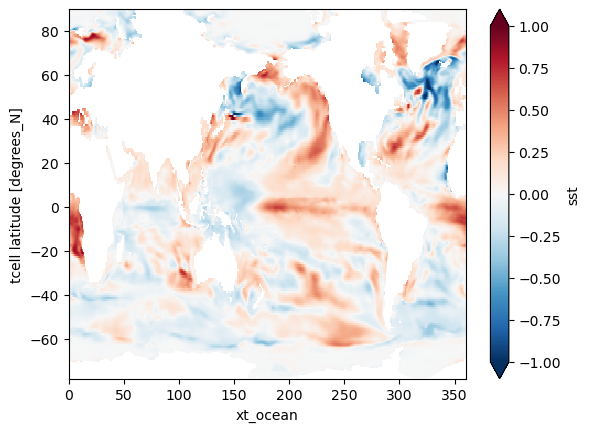

In [21]:
(VC_son_ssta.where(VC_son_ssta.year == pp_VC.year).mean("year") - 
 ctrl_son_ssta.where(ctrl_son_ssta.year == pp_ctrl.year).mean("year")).plot(vmin = -1)

In [22]:
#load in Omega at equator and analyse if there is much difference in walker cell (and anomalies form claimtology during mean
#IOD events, pure and co-occurring events. This will help tell usabout the dynamics with the bias

In [3]:
ctrl_om = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_om/ctrl_om*.nc",
                          use_cftime=True, chunks= {"time":240})
#ctrl_om = regrid_ACCESS_atmos_u(ctrl_om, 'fld_s30i208')
ctrl_om = ctrl_om.fld_s30i208.compute()

In [4]:
VC_om = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_om/VC_om*.nc",
                          use_cftime=True, chunks= {"time":240})
#VC_om = regrid_ACCESS_atmos_u(VC_om, 'fld_s30i208')
VC_om = VC_om.fld_s30i208.compute()

In [5]:
VC_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_u/VC_u*.nc",
                          use_cftime=True, chunks= {"time":240})
VC_u = VC_u.fld_s30i201.compute()

In [ ]:
ctrl_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_u/ctrl_u*.nc",
                          use_cftime=True)
ctrl_u = ctrl_u.fld_s30i201.compute()

2023-11-12 16:18:27,604 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:38395 -> None
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/worker.py", line 1768, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/comm/tcp.py", line 241, in

In [25]:
ctrl_sst = ctrl_sst.sel(time = slice("0951-01-01", "1150-12-31"))

In [26]:
ctrl_om['time'] = ctrl_sst.time
VC_om['time'] = VC_sst.time

In [27]:
#calculate the latitude bands of the omega

In [ ]:
ctrl_om_eq = ctrl_om.sel(lat_v = slice(-5,5)).mean("lat_v")

In [ ]:
VC_om_eq = VC_om.sel(lat_v = slice(-5,5)).mean("lat_v")

In [ ]:
ctrl_u_eq = ctrl_u.sel(lat_v = slice(-5,5)).mean("lat_v")

In [ ]:
VC_u_eq = VC_u.sel(lat_v = slice(-5,5)).mean("lat_v")

In [ ]:
ctrl_son_OM_eq = calc_seasonal_TS((ctrl_om_eq), "SON")

In [ ]:
ctrl_djf_OM_eq = calc_seasonal_TS((ctrl_om_eq), "DJF")

In [ ]:
ctrl_jja_OM_eq = calc_seasonal_TS((ctrl_om_eq), "JJA")

In [ ]:
ctrl_mam_OM_eq = calc_seasonal_TS((ctrl_om_eq), "MAM")

In [ ]:
VC_mam_OM_eq = calc_seasonal_TS((VC_om_eq), "MAM")
VC_jja_OM_eq = calc_seasonal_TS((VC_om_eq), "JJA")
VC_son_OM_eq = calc_seasonal_TS((VC_om_eq), "SON")
VC_djf_OM_eq = calc_seasonal_TS((VC_om_eq), "DJF")

In [ ]:
VC_mam_u_eq = calc_seasonal_TS((VC_u_eq), "MAM")
VC_jja_u_eq = calc_seasonal_TS((VC_u_eq), "JJA")
VC_son_u_eq = calc_seasonal_TS((VC_u_eq), "SON")
VC_djf_u_eq = calc_seasonal_TS((VC_u_eq), "DJF")

In [ ]:
ctrl_mam_u_eq = calc_seasonal_TS((ctrl_u_eq), "MAM")
ctrl_jja_u_eq = calc_seasonal_TS((ctrl_u_eq), "JJA")
ctrl_son_u_eq = calc_seasonal_TS((ctrl_u_eq), "SON")
ctrl_djf_u_eq = calc_seasonal_TS((ctrl_u_eq), "DJF")

/jobfs/100377003.gadi-pbs/ipykernel_2171552/1720470422.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


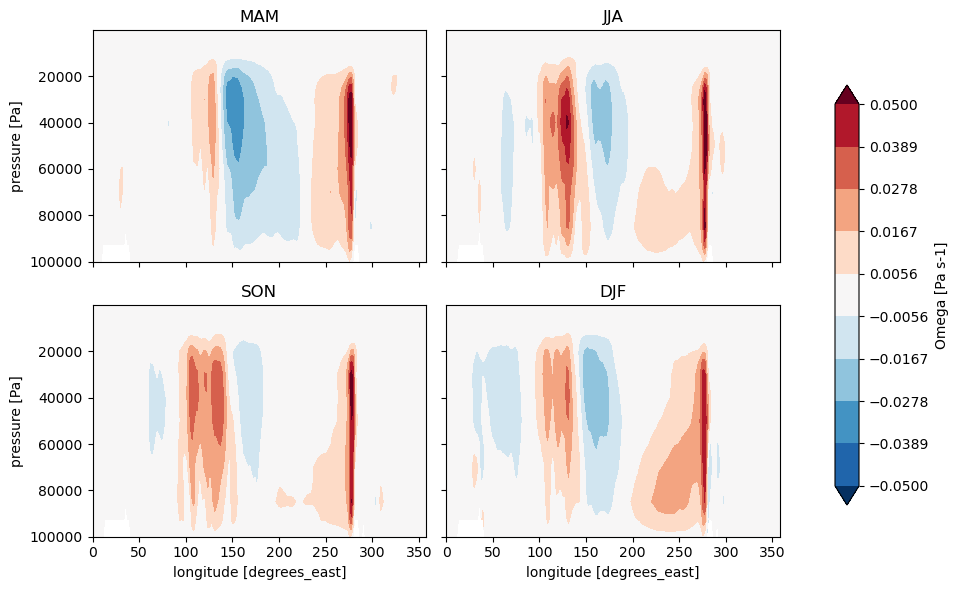

In [35]:
fg, ax = plt.subplots(nrows =2, ncols = 2, sharex=True, sharey=True, figsize=(8, 6))
c = (VC_mam_OM_eq.mean("year") - ctrl_mam_OM_eq.mean("year")).plot.contourf(ax = ax[0,0], yincrease = False,
                                     extend = "both", vmin = -0.05, levels = 10, add_colorbar = False)
(VC_jja_OM_eq.mean("year") - ctrl_jja_OM_eq.mean("year")).plot.contourf(ax = ax[0,1], yincrease = False,
                                     extend = "both", vmin = -0.05, levels = 10, add_colorbar = False)
(VC_son_OM_eq.mean("year") - ctrl_son_OM_eq.mean("year")).plot.contourf(ax = ax[1,0], yincrease = False,
                                     extend = "both", vmin = -0.05, levels = 10, add_colorbar = False)
(VC_djf_OM_eq.mean("year") - ctrl_djf_OM_eq.mean("year")).plot.contourf(ax = ax[1,1], yincrease = False,
                                     extend = "both", vmin = -0.05, levels = 10, add_colorbar = False)
# Set titles for each panel
ax[0, 0].set_title("MAM")
ax[0, 1].set_title("JJA")
ax[1, 0].set_title("SON")
ax[1, 1].set_title("DJF")

# Set axis labels only on the left-hand side and the bottom row
for i in range(2):
    for j in range(2):
        if i > 0: 
             ax[j, i].set_ylabel("")
        if j < 1:
            ax[j, i].set_xlabel("")
cbar_ax = fg.add_axes([1.05, 0.15, 0.03, 0.7])  # Adjust the position and size as needed

# Add the colorbar to the right-hand axis
cbar = plt.colorbar(c, cax=cbar_ax)

# Set a label for the colorbar (if needed)
cbar.set_label("Omega [Pa s-1]")
plt.tight_layout()

/jobfs/99759717.gadi-pbs/ipykernel_568626/1054525411.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


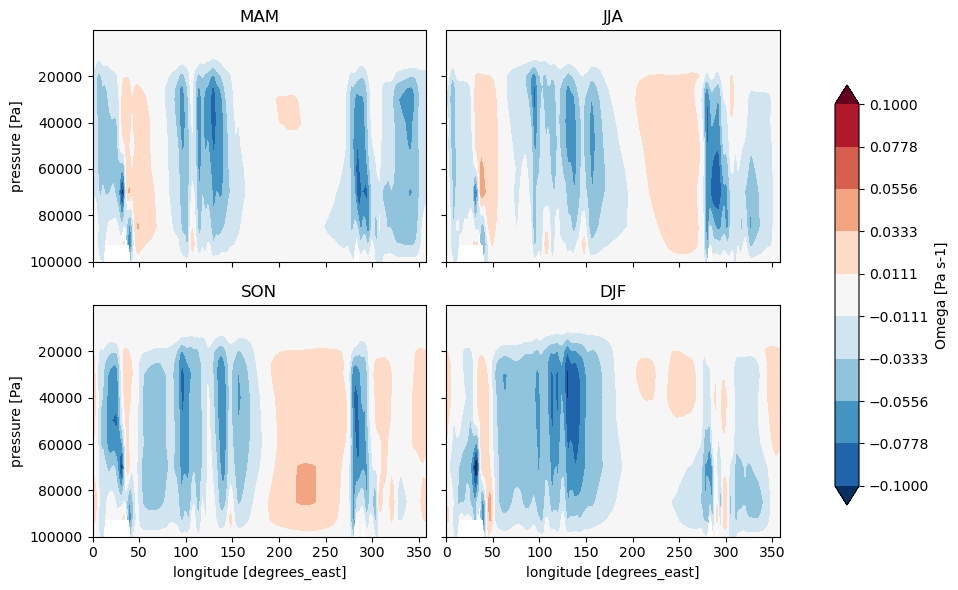

In [59]:
fg, ax = plt.subplots(nrows =2, ncols = 2, sharex=True, sharey=True, figsize=(8, 6))
c = ctrl_mam_OM_eq.mean("year").plot.contourf(ax = ax[0,0], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
ctrl_jja_OM_eq.mean("year").plot.contourf(ax = ax[0,1], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
ctrl_son_OM_eq.mean("year").plot.contourf(ax = ax[1,0], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
ctrl_djf_OM_eq.mean("year").plot.contourf(ax = ax[1,1], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
# Set titles for each panel
ax[0, 0].set_title("MAM")
ax[0, 1].set_title("JJA")
ax[1, 0].set_title("SON")
ax[1, 1].set_title("DJF")

# Set axis labels only on the left-hand side and the bottom row
for i in range(2):
    for j in range(2):
        if i > 0: 
             ax[j, i].set_ylabel("")
        if j < 1:
            ax[j, i].set_xlabel("")
cbar_ax = fg.add_axes([1.05, 0.15, 0.03, 0.7])  # Adjust the position and size as needed

# Add the colorbar to the right-hand axis
cbar = plt.colorbar(c, cax=cbar_ax)

# Set a label for the colorbar (if needed)
cbar.set_label("Omega [Pa s-1]")
plt.tight_layout()

/jobfs/99759717.gadi-pbs/ipykernel_568626/1879255362.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


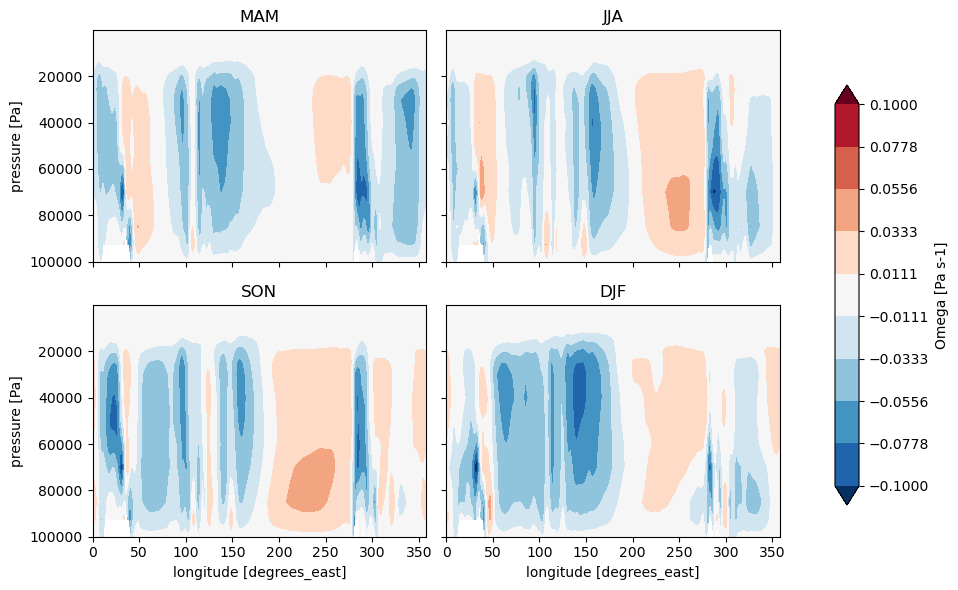

In [55]:
fg, ax = plt.subplots(nrows =2, ncols = 2, sharex=True, sharey=True, figsize=(8, 6))
c = VC_mam_OM_eq.mean("year").plot.contourf(ax = ax[0,0], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
VC_jja_OM_eq.mean("year").plot.contourf(ax = ax[0,1], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
VC_son_OM_eq.mean("year").plot.contourf(ax = ax[1,0], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
VC_djf_OM_eq.mean("year").plot.contourf(ax = ax[1,1], yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10, add_colorbar = False)
# Set titles for each panel
ax[0, 0].set_title("MAM")
ax[0, 1].set_title("JJA")
ax[1, 0].set_title("SON")
ax[1, 1].set_title("DJF")

# Set axis labels only on the left-hand side and the bottom row
for i in range(2):
    for j in range(2):
        if i > 0: 
             ax[j, i].set_ylabel("")
        if j < 1:
            ax[j, i].set_xlabel("")
cbar_ax = fg.add_axes([1.05, 0.15, 0.03, 0.7])  # Adjust the position and size as needed

# Add the colorbar to the right-hand axis
cbar = plt.colorbar(c, cax=cbar_ax)

# Set a label for the colorbar (if needed)
cbar.set_label("Omega [Pa s-1]")
plt.tight_layout()

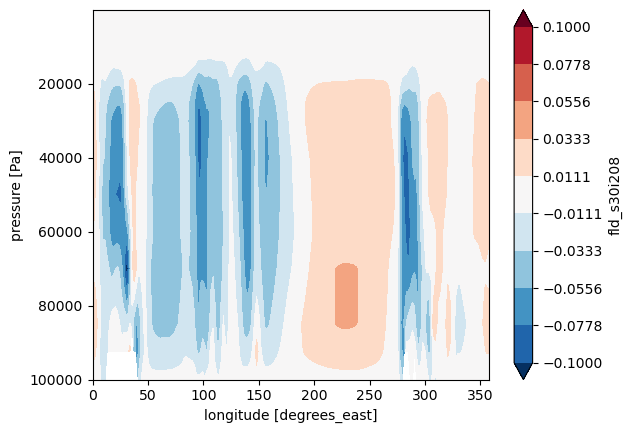

In [32]:
ctrl_son_OM_eq.mean("year").plot.contourf(yincrease = False,
                                     extend = "both", vmin = -0.1, levels = 10)

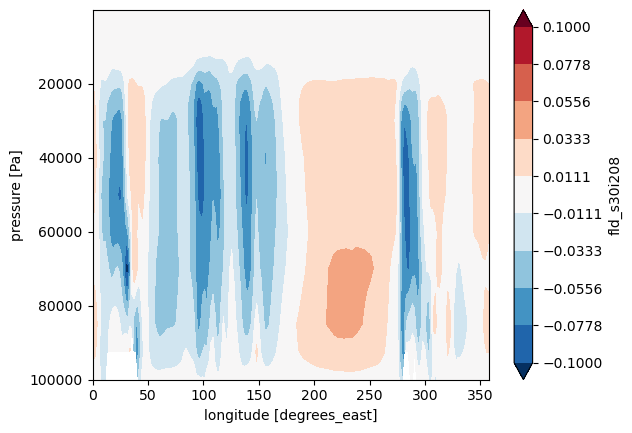

In [321]:
ctrl_son_OM_eq.where(ctrl_son_OM_eq.year == pn_ctrl.year).mean("year").plot.contourf(yincrease = False,
                                                                                     extend = "both", vmin = -0.1, levels = 10)

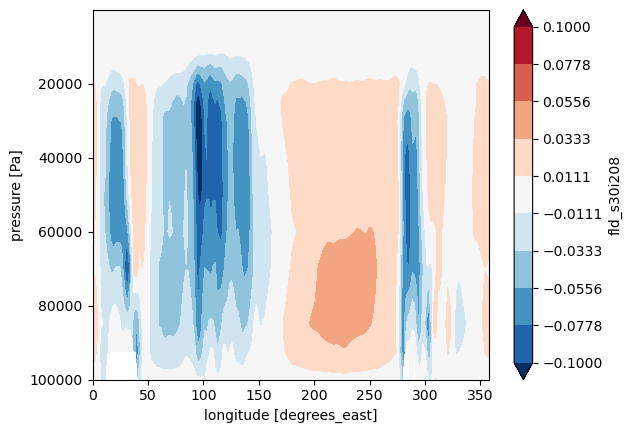

In [320]:
ctrl_son_OM_eq.where(ctrl_son_OM_eq.year == cn_ctrl.year).mean("year").plot.contourf(yincrease = False,
                                                                                     extend = "both", vmin = -0.1, levels = 10)

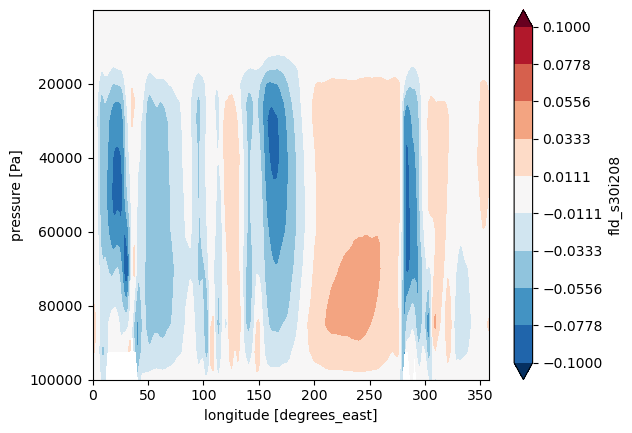

In [324]:
VC_son_OM_eq.where(VC_son_OM_eq.year == pp_VC.year).mean("year").plot.contourf(yincrease = False,
                                                                                    extend = "both", vmin = -0.1, levels = 10)

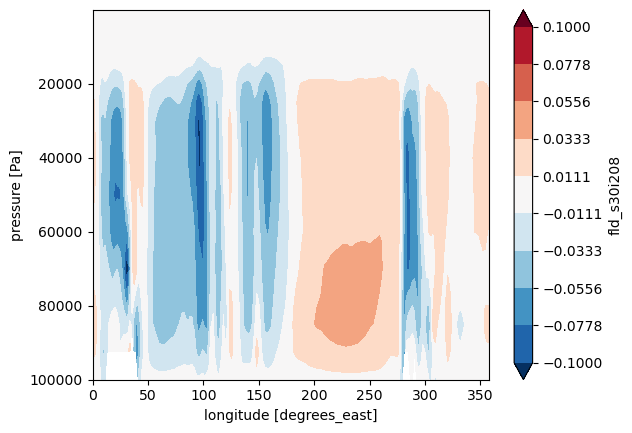

In [327]:
VC_son_OM_eq.where(VC_son_OM_eq.year == pn_VC.year).mean("year").plot.contourf(yincrease = False,
                                                                                    extend = "both", vmin = -0.1, levels = 10)

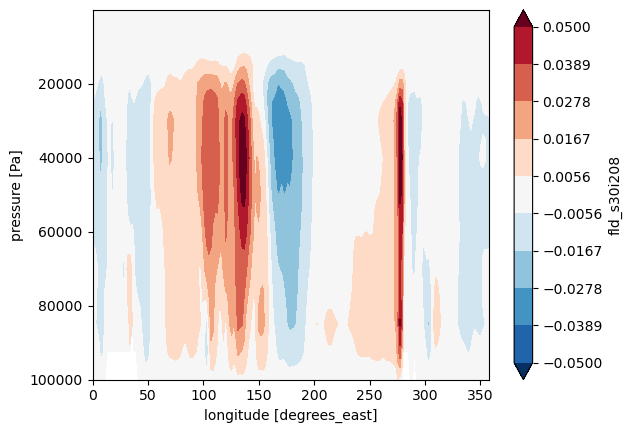

In [329]:
(VC_son_OM_eq.where(VC_son_OM_eq.year == pp_VC.year).mean("year") -  
 ctrl_son_OM_eq.where(ctrl_son_OM_eq.year == pp_ctrl.year).mean("year")).plot.contourf(yincrease = False,
                                                                                    extend = "both", vmin = -0.05, levels = 10)

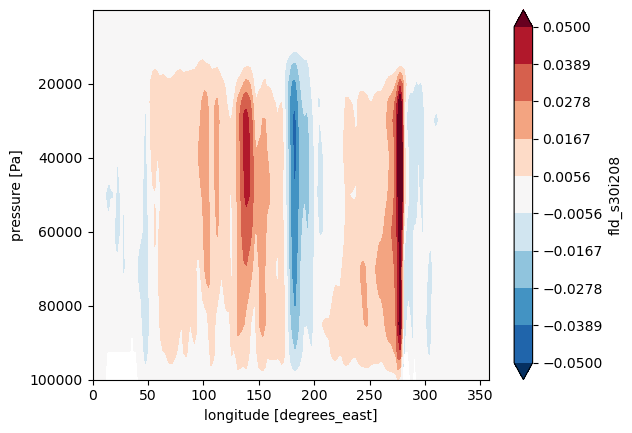

In [330]:
(VC_son_OM_eq.where(VC_son_OM_eq.year == cp_VC.year).mean("year") -  
 ctrl_son_OM_eq.where(ctrl_son_OM_eq.year == cp_ctrl.year).mean("year")).plot.contourf(yincrease = False,
                                                                                    extend = "both", vmin = -0.05, levels = 10)